# Pengambilan Data

In [ ]:
import tweepy
import csv
import pandas as pd
import datetime

In [ ]:
consumer_key = 'IWUfRhxvE5GwixI8Lp0d2JGs0'
consumer_secret = 'ACxzjt91JD4xWmfo0yKnXjMqY10RW4dPQs34QJv0Cfr5rgjMYM'
access_token = '1318531052600635397-efAuRcwTU1brFFvaFo7Fksjcj7dcbL'
access_token_secret = 'mPWKNo7sZRcPFKygFizOGNzkLou5Yr49O5GA5XYsyxgwl'

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print("Terjadi masalah dalam autentifikasi API")
searchQuery = 'kartu prakerja'

maxTweets = 100

tweetsPerQry = 10
tweetCount = 0
csvFile = open('hasil_5Agustus.csv','a')

csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search, q=searchQuery, lang='id').items():
        csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])
csvFile.close()

print("Download beberapa tweet".format(tweetCount))

# Preprocessing Data

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import nltk, emoji, re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
data = pd.read_csv("hasil_21Juli.csv",nrows=2000,names=['tanggal','tweet']).dropna()
data.drop(['tanggal'], axis=1, inplace=True)

data.head()

In [ ]:
def url_remove(text):
    t = re.sub(r'https://\S+','',text)
    return t

def punc_remove(text):
    t = re.sub(r'[^\w\s]','',text)
    return t

def number_remove(text):
    t = re.sub(r"\d+", "", text)
    return t

def regex_remove(text):
    reg = "b'" 
    return re.sub(reg, " ", text)

def emoji_remove(text):
    return emoji.get_emoji_regexp().sub("", text).strip()

def hashtag_remove(text):
    reg = "#(\w+)"
    return re.sub(reg, " ", text)

cleaned = []

def clean_text(text):
    for i in text:
        cleaned.append(emoji_remove(punc_remove(number_remove(regex_remove(hashtag_remove(url_remove(
            re.sub("[\n\r\t\xa0]"," ",i).strip())))))))
clean_text(data["tweet"])

In [ ]:
data['text'] = cleaned

data.head()

In [ ]:
def lowercase():
    lower_word = data['text'].str.lower()
    return lower_word

lower_tweet = lowercase()

print(lower_tweet)

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
more_stopword = ['rt', 'anjing','anjir','pantek']
stopword = factory.create_stop_word_remover()
stopwords = factory.get_stop_words()+more_stopword
print(stopwords)

In [ ]:
def removeStopWords(text):
    clean_word_list = [word for word in text.split() if word not in stopwords]
    return clean_word_list

stopwords_tweet = lower_tweet.apply(removeStopWords)

print(stopwords_tweet)

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in stopwords_tweet:
    for term in document:
        if term not in term_dict:
            term_dict[term] = " "
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")

def get_stemmed_term(document):
    return [term_dict[term] for term in document]

stem_tweet = stopwords_tweet.apply(get_stemmed_term)

print(stem_tweet)

In [ ]:
normalizad_word = pd.read_excel("normalization.xlsx")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

normal_tweet = stem_tweet.apply(normalized_term).str.join(" ")

print(normal_tweet)

In [ ]:
data_preprocess = normal_tweet

data_preprocess

In [ ]:
tt={"Text":data['tweet'], "Cleaned_Text":data_preprocess}

df=pd.DataFrame(tt)
df.to_excel("hasil_preprocess_21Juli.xlsx")

# Pelabelan Manual

In [3]:
import numpy as np
import pandas as pd
import re

In [4]:
tweet_dataset = pd.read_excel("pelabelan_fix_ditambah.xlsx")
tweet_dataset = tweet_dataset[['No','Kelas','Label','Cleaned_Text']]

tweet_dataset

,No,Kelas,Label,Cleaned_Text
0,1,Positif,1,kalau butuh bimbing ikut skill academy aja ata...
1,2,Positif,1,iseng ngecek prakerja punya ibu eh nyata lolos
2,3,Positif,1,alhamdulillah udah manfaat prakerja sampai sal...
3,4,Positif,1,ingat hari akhir beli latih serta kartu praker...
4,5,Positif,1,akhir april ini peserta kartu prakerja gelomba...
...,...,...,...,...
995,996,Negatif,0,nirmala hadeh ane saja belum pernah ngerasain ...
996,997,Negatif,0,konon dengar dengar sih bansos kali guna siste...
997,998,Negatif,0,punya tetangga unik militan benci jokowi vaksi...
998,999,Negatif,0,nirmala yang vaksin ancamanya gaji perusahaany...


In [5]:
tweet_dataset.Label.value_counts()

0    500
1    500
Name: Label, dtype: int64

# Training Data

In [6]:
tweet_dataset = pd.read_excel("pelabelan_fix_ditambah.xlsx")

tweet_dataset = tweet_dataset[['No','Kelas','Label','Cleaned_Text']].fillna(' ')

tweet_dataset

,No,Kelas,Label,Cleaned_Text
0,1,Positif,1,kalau butuh bimbing ikut skill academy aja ata...
1,2,Positif,1,iseng ngecek prakerja punya ibu eh nyata lolos
2,3,Positif,1,alhamdulillah udah manfaat prakerja sampai sal...
3,4,Positif,1,ingat hari akhir beli latih serta kartu praker...
4,5,Positif,1,akhir april ini peserta kartu prakerja gelomba...
...,...,...,...,...
995,996,Negatif,0,nirmala hadeh ane saja belum pernah ngerasain ...
996,997,Negatif,0,konon dengar dengar sih bansos kali guna siste...
997,998,Negatif,0,punya tetangga unik militan benci jokowi vaksi...
998,999,Negatif,0,nirmala yang vaksin ancamanya gaji perusahaany...


In [7]:
def import_tweets():
    tweet_dataset.columns = ['No', 'Kelas','Label','Cleaned_Text']
    tweet_dataset.sentiment = tweet_dataset.sentiment.replace(4,1)
    return tweet_dataset

In [8]:
def feature_extraction(data, method = "tfidf"):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfv=TfidfVectorizer(sublinear_tf=True) 
    features=tfv.fit_transform(data)
    return features

In [9]:
def train_classifier(features, label, classifier = "naive_bayes"):
    from sklearn.metrics import roc_auc_score
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB()
    model.fit(features, label)
    probability_to_be_positive = model.predict_proba(features)[:,1]
    
    print ("auc (train data):" , roc_auc_score(label, probability_to_be_positive))
    print ("top 10 scores: ", probability_to_be_positive[:10])

In [10]:
data = np.array(tweet_dataset.Cleaned_Text)
label = np.array(tweet_dataset.Label)

In [11]:
features = feature_extraction(data, method = "tfidf") 

print(features)

  (0, 928)	0.23537904336769414
  (0, 2146)	0.3360480736433859
  (0, 1219)	0.3109749081635186
  (0, 2189)	0.21429039416282666
  (0, 1686)	0.06058453697454565
  (0, 1175)	0.1868222093357075
  (0, 409)	0.17115100877875056
  (0, 128)	0.3109749081635186
  (0, 31)	0.25018979384075496
  (0, 2)	0.2739977597360192
  (0, 1957)	0.24227206913121327
  (0, 802)	0.21429039416282666
  (0, 262)	0.38492920501851746
  (0, 331)	0.29907092521588646
  (0, 947)	0.21112034788630074
  (1, 1210)	0.27181174468603886
  (1, 1508)	0.33608954620722586
  (1, 584)	0.35788363135794704
  (1, 788)	0.40966545780668334
  (1, 1724)	0.3089348663820094
  (1, 1432)	0.4560866895809244
  (1, 841)	0.4560866895809244
  (1, 1686)	0.07605802373713891
  (2, 251)	0.3763945080097555
  (2, 1142)	0.3040799347920501
  :	:
  (998, 2031)	0.41938089894321784
  (998, 1642)	0.41938089894321784
  (998, 77)	0.41938089894321784
  (998, 1476)	0.25644579188318406
  (998, 2237)	0.27495475460052354
  (998, 649)	0.338807590679245
  (998, 277)	0.243829

In [12]:
train = train_classifier(features, label, "naive_bayes")

print(train)

#accuracy menggunakan k-fold cross validation
#train disimpan dalam bentuk .pickle

#cara menyimpan model classifier dalam file pickle/tanpa perlu dirunning

auc (train data): 0.992938
top 10 scores:  [0.84997974 0.54954297 0.78201502 0.81890835 0.92676238 0.79375348
 0.88411982 0.54202429 0.78791271 0.58874025]
None


# Testing

In [13]:
import pandas as pd 
import numpy as np 
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [14]:
data = pd.read_excel('pelabelan_fix_ditambah.xlsx')
data = data[['No','Kelas','Label','Cleaned_Text']]

data

,No,Kelas,Label,Cleaned_Text
0,1,Positif,1,kalau butuh bimbing ikut skill academy aja ata...
1,2,Positif,1,iseng ngecek prakerja punya ibu eh nyata lolos
2,3,Positif,1,alhamdulillah udah manfaat prakerja sampai sal...
3,4,Positif,1,ingat hari akhir beli latih serta kartu praker...
4,5,Positif,1,akhir april ini peserta kartu prakerja gelomba...
...,...,...,...,...
995,996,Negatif,0,nirmala hadeh ane saja belum pernah ngerasain ...
996,997,Negatif,0,konon dengar dengar sih bansos kali guna siste...
997,998,Negatif,0,punya tetangga unik militan benci jokowi vaksi...
998,999,Negatif,0,nirmala yang vaksin ancamanya gaji perusahaany...


In [15]:
def convert(polarity):
    if polarity == 'Positif':
        return 1
    elif polarity == 'Negatif':
        return 0

In [16]:
data['polarity'] = data['Kelas'].apply(convert)

In [17]:
X = data['Cleaned_Text']
y = data['polarity']

bow_transformer = CountVectorizer().fit(data['Cleaned_Text'])
messages_bow = bow_transformer.transform(data['Cleaned_Text'])

tfidf_transformer = TfidfTransformer().fit(messages_bow)

messages_tfidf = tfidf_transformer.transform(messages_bow)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(data['Cleaned_Text'],data['polarity'],test_size=0.1,random_state=100)

pipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

X_train = np.asarray(X)
pipeline = pipeline.fit(X_train, np.asarray(y))

In [19]:
file_data = 'latihan.pickle'
f = open(file_data, 'wb')
pickle.dump(pipeline, f)
f.close()

In [20]:
file_dataset = 'latihan.pickle'
f = open(file_dataset, 'rb')
training = pickle.load(f)
f.close()
print(training)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])


In [21]:
data_tweet = pd.read_excel('pelabelan_fix_2.xlsx')

data_tweet = data_tweet['Cleaned_Text']

data_tweet = data_tweet.fillna(' ')

data_tweet

0       anibidadari jauh dampak positif kartu prakerja...
1       schfess hese menang prakerja bantu umkm da nu ...
2       juli sebentar siapsiap buka kartu prakerja gel...
3       anibidadari jauh dampak positif kartu prakerja...
4       ugmbergerak jokowi ugmyogyakarta gjynmmnggllag...
                              ...                        
6653    konon dengar dengar sih bansos kali guna siste...
6654    atamimipasaribu nirmala chusnulch bijak yang m...
6655    punya tetangga unik militan benci jokowi vaksi...
6656    nirmala yang vaksin ancamanya gaji perusahaany...
6657    nirmala memang vaksin blt kartu prakerja rsud ...
Name: Cleaned_Text, Length: 6658, dtype: object

In [22]:
prediction = training.predict(np.asarray(data_tweet))

In [23]:
prediction

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [24]:
result = []

for i in range(len(prediction)):
    if(prediction[i]==1):
        sentiment = 'Positif'
    elif(prediction[i]==0):
        sentiment = 'Negatif'
    
    result.append({'Cleaned_Text':data_tweet[i],'Label':prediction[i],'Kelas':sentiment})

In [40]:
data = pd.DataFrame(result)

data

,Cleaned_Text,Label,Kelas
0,anibidadari jauh dampak positif kartu prakerja...,1,Positif
1,schfess hese menang prakerja bantu umkm da nu ...,1,Positif
2,juli sebentar siapsiap buka kartu prakerja gel...,1,Positif
3,anibidadari jauh dampak positif kartu prakerja...,1,Positif
4,ugmbergerak jokowi ugmyogyakarta gjynmmnggllag...,0,Negatif
...,...,...,...
6653,konon dengar dengar sih bansos kali guna siste...,0,Negatif
6654,atamimipasaribu nirmala chusnulch bijak yang m...,0,Negatif
6655,punya tetangga unik militan benci jokowi vaksi...,0,Negatif
6656,nirmala yang vaksin ancamanya gaji perusahaany...,0,Negatif


In [41]:
positif = data.loc[data['Kelas'] == 'Positif' , 'Cleaned_Text']

positif

0       anibidadari jauh dampak positif kartu prakerja...
1       schfess hese menang prakerja bantu umkm da nu ...
2       juli sebentar siapsiap buka kartu prakerja gel...
3       anibidadari jauh dampak positif kartu prakerja...
5       jangan siasiakan serta kartu prakerja bantu rp...
                              ...                        
6621    kartu prakerja bantu biaya latih masyarakat in...
6622    program prakerja salur bantu upa uang prakerja...
6634    nahh kaca mekanisme distribusi kartu prakerja ...
6635    kemenkeuri terima kartu prakerja amp subsidi u...
6639    nnuang rp triliun keluar bantu via kartu prake...
Name: Cleaned_Text, Length: 4474, dtype: object

In [27]:
from nltk import FreqDist

fdist1 = FreqDist(positif)

print(fdist1.most_common(10))

[('maspiyuaja agustinus edy kristianto wuidih perintah tambah anggar program kartu prakerja jadi rp triliun pesta pora si', 341), ('msaid didu anggar covid naik rp trilyun kartu prakerja malah naik jadi rp trilyun pmn bumn mau tambah rp tr', 180), ('hasbil lbs juta org terima kartu prakerja serta paket manfaat nila rp juta arti perintah u ', 100), ('geloraco sri mulyani tambah anggar kartu prakerja jadi rp triliunn', 62), ('ricapepedas jangkau luas buat efektivitas manfaat kartu prakerja nikmat seluruh lapis masyarakat sa ', 58), ('jangkau luas buat efektivitas manfaat kartu prakerja nikmat seluruh lapis masyara ', 44), ('chusnulch tol laut jokowi maksimal distribusi siap pon xx papuannsama dgn kebijakn yang kartu prakerja d', 39), ('oposisicerdas sri mulyani suntik rp triliun program kartu prakerja fadli zon program buangbuang uangn', 33), ('kretagama ri harap tambah anggar program kartu prakerja kurang ekses negatif laku ppkm da', 33), ('fadlizon sri mulyani suntik program kartu prak

In [28]:
negatif = data.loc[data['Kelas'] == 'Negatif' , 'Cleaned_Text']

negatif

4       ugmbergerak jokowi ugmyogyakarta gjynmmnggllag...
6                     wkwk saya mau dftr prakerja aja kgk
10      robonggo pasuro sedang ecek hasil verifikasi k...
11      dutijulian helenmnrng ka ngakak sama tetap war...
13      mau tanya siapa tau aja lewat tl prakerja udh ...
                              ...                        
6653    konon dengar dengar sih bansos kali guna siste...
6654    atamimipasaribu nirmala chusnulch bijak yang m...
6655    punya tetangga unik militan benci jokowi vaksi...
6656    nirmala yang vaksin ancamanya gaji perusahaany...
6657    nirmala memang vaksin blt kartu prakerja rsud ...
Name: Cleaned_Text, Length: 2184, dtype: object

In [29]:
from nltk import FreqDist

fdist2 = FreqDist(negatif)

print(fdist2.most_common(10))

[('fadlizon program kartu prakerja tak jelas buang uang untuk latih padahal gratis baik uang kartu prakerja langsung d', 418), ('chusnulch orang yang tahun lalu kritik keras program kartu prakerja bahkan yang minta batalkannlihat hasil skrng yang dinikmati ', 74), ('fadlizon program kartu prakerja suntik t fadli zon buangbuang uang nlebih baik anggar nakesn', 64), ('fadlizon goriau kritik program kartu prakerja fadli zon tak jelas cuma buangbuang uang', 44), ('msaid didu kartu prakerja naik jadi rp trilyun', 40), ('chusnulch sblmnya soal bus listriknlalu soal konflik agrariankawal kartu prakerjanbagikan ivermectin bbrp daerahnskrng terkai', 29), ('msaid didu gara bayar cicil utang bunga pokok sktr rp trilyun per bulan paksa tdk bayar utang rum', 28), ('msaid didu dana kartu prakerja beri rp trilyun', 28), ('rizkidwiirfan kompastv bukan cuma daftar vaksin doang data tidak pake buat daftar prakerja padahal perna', 19), ('fadlizon komentar fadli zon kait anggar kartu prakerjan', 14)]


In [30]:
data.groupby(by='Kelas').agg('count')

,Cleaned_Text,Label
Kelas,,
Negatif,2184,2184
Positif,4474,4474


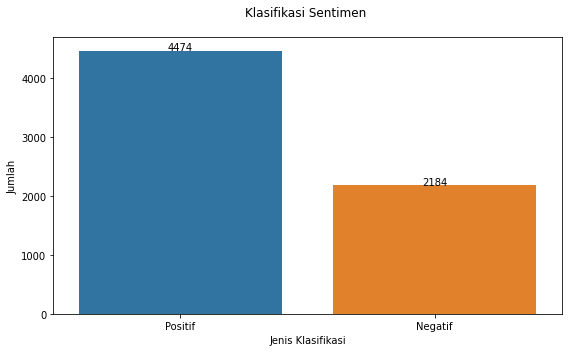

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [8,5]
plt.rcParams["figure.autolayout"] = True
x = ['Positif', 'Negatif',]
y = [4474,2184]
percentage = [4474,2184]
ax = sns.barplot(x=x, y=y)
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.5
    ax.annotate('{:}'.format(percentage[i]), (x, y), ha='center')
    
plt.title('Klasifikasi Sentimen \n')
plt.xlabel('Jenis Klasifikasi')
plt.ylabel('Jumlah')    
plt.show()

# Klasifikasi

In [32]:
import pandas as pd 
import numpy as np 
import re

#dataset = pd.read_excel("pelabelan_fix_ditambah.xlsx")
#dataset = dataset[['No','Kelas','Label','Cleaned_Text']]
dataset = data

dataset

,Cleaned_Text,Label,Kelas
0,anibidadari jauh dampak positif kartu prakerja...,1,Positif
1,schfess hese menang prakerja bantu umkm da nu ...,1,Positif
2,juli sebentar siapsiap buka kartu prakerja gel...,1,Positif
3,anibidadari jauh dampak positif kartu prakerja...,1,Positif
4,ugmbergerak jokowi ugmyogyakarta gjynmmnggllag...,0,Negatif
...,...,...,...
6653,konon dengar dengar sih bansos kali guna siste...,0,Negatif
6654,atamimipasaribu nirmala chusnulch bijak yang m...,0,Negatif
6655,punya tetangga unik militan benci jokowi vaksi...,0,Negatif
6656,nirmala yang vaksin ancamanya gaji perusahaany...,0,Negatif


In [33]:
clean_msg = pd.DataFrame(dataset,columns=['Cleaned_Text'])
clean_msg.head()

X = clean_msg.Cleaned_Text

dataset['sentiment'] = dataset['Kelas'].apply(lambda x: 0 if x=='Negatif' else (1 if x== 'Positif' else 2))
Y = dataset.sentiment
print(Y)

0       1
1       1
2       1
3       1
4       0
       ..
6653    0
6654    0
6655    0
6656    0
6657    0
Name: sentiment, Length: 6658, dtype: int64


In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(analyzer = "word",min_df=0.0004,max_df=0.115, ngram_range=(1,3))
vect.fit(X_train) 
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [37]:
nbmodel = MultinomialNB(alpha=0.1)
nbmodel = nbmodel.fit(X_train_dtm,Y_train)
Y_pred = nbmodel.predict(X_test_dtm)
print(accuracy_score(Y_test,Y_pred))

0.9617117117117117


In [38]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(Y_test, Y_pred) 
print(cm)

[[403  16]
 [ 35 878]]


In [39]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       419
           1       0.98      0.96      0.97       913

    accuracy                           0.96      1332
   macro avg       0.95      0.96      0.96      1332
weighted avg       0.96      0.96      0.96      1332



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = nbmodel, X = X_train_dtm, y = Y_train, cv = 10) 
print('Rata-rata akurasi yaitu: ', accuracies.mean())

In [ ]:
accuracies

In [ ]:
accuracy = accuracies*100

print('Accuracy yang dicari (dalam %) yaitu: ', accuracy)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["figure.autolayout"] = True

x = [1,2,3,4,5,6,7,8,9,10]
y = accuracy

percentage = accuracy
ax = sns.barplot(x=x, y=y)
patches = ax.patches

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.5
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
    
plt.title('K-Fold Cross Validation Naive Bayes Classification \n')
plt.xlabel('Urutan Fold')
plt.ylabel('Accuracy')
plt.show()